In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
%matplotlib inline
warnings.simplefilter("ignore")

### Read the data using pandas

In [2]:
df_train = pd.read_csv('data/train.csv', index_col="PassengerId")

In [3]:
df_test = pd.read_csv('data/test.csv', index_col="PassengerId")

In [4]:
df_full = pd.concat([df_train,df_test])

In [5]:
df_full.head()

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket
PassengerId,,,,,,,,,,,
1,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,3,male,1,0.0,A/5 21171
2,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,female,1,1.0,PC 17599
3,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,female,0,1.0,STON/O2. 3101282
4,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,female,1,1.0,113803
5,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,3,male,0,0.0,373450


In [6]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 11 columns):
Age         1046 non-null float64
Cabin       295 non-null object
Embarked    1307 non-null object
Fare        1308 non-null float64
Name        1309 non-null object
Parch       1309 non-null int64
Pclass      1309 non-null int64
Sex         1309 non-null object
SibSp       1309 non-null int64
Survived    891 non-null float64
Ticket      1309 non-null object
dtypes: float64(3), int64(3), object(5)
memory usage: 122.7+ KB


### Obervations:
1. Females have a higher probability of surviving

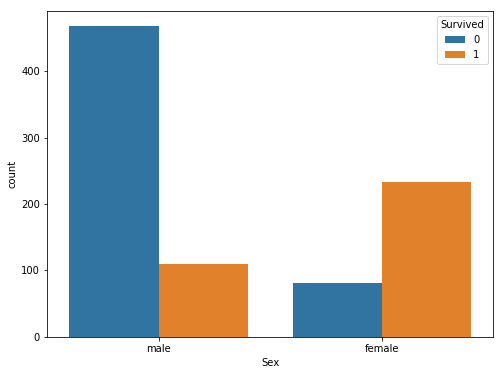

In [7]:
plt.figure(figsize=(8,6))
sns.countplot(x='Sex',data=df_train, hue='Survived')

### Observations
1. First and Second class have higher probability of survival

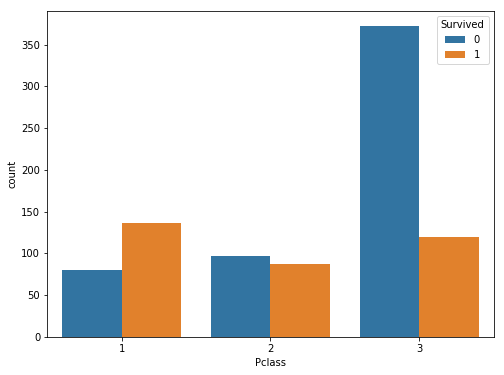

In [8]:
plt.figure(figsize=(8,6))
sns.countplot(x='Pclass',data=df_train, hue='Survived')

### Obervations
1. C has a highest probaility of survival
1. Q has higher ratio of survival than S

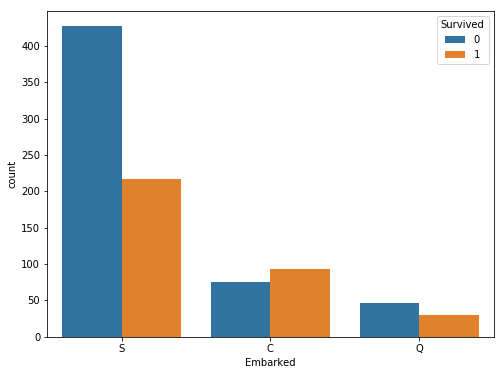

In [9]:
plt.figure(figsize=(8,6))
sns.countplot(x='Embarked',data=df_train, hue='Survived')

### Observations
1. Cabin should be dropped since it is null
1. Age should be imputed
1. Fare should be imputed as well.

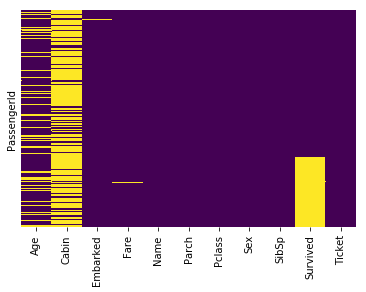

In [10]:
sns.heatmap(df_full.isnull(),yticklabels=False,cbar=False,cmap='viridis')

## Data Transformation
1. Impute Age and Fare.
2. Apply Feature Scaling to Fare.
3. Drop Cabin
4. 1 Hot encoder for Port of Embarkation
5. 1 Hot encoder for Sex
6. Drop any non numerical or transformed column.

## Feature Engineering:
* Age Brackets
 * Infant 0 to 1
 * Toddler 1 to 3
 * Child 4 to 10
 * Teenager 11 to 19
 * Young Adult 20 to 30
 * Adults 30 to 50
 * Senior 51 and more


* Family Size:
 * 1 + SibSp


* Family Relationships:
 * Has children: Age > 18 and Parch > 0
 * Has Parents: Age < 18 and Parch > 0
 * Has a nanny: Age < 18 and Parch = 0


### Impute Age
1. Get median based on Sex and Pclass

In [11]:
age_median  = {}
for i in range(1,4):
    male_index = 'male' + str(i)
    female_index = 'female' + str(i)
    age_median[male_index] = df_full[(df_full['Sex']=='male') & (df_full['Pclass']==i)]['Age'].median()
    age_median[female_index] = df_full[(df_full['Sex']=='female') & (df_full['Pclass']==i)]['Age'].median()

def impute_age(cols):
    age = cols[0]
    Pclass = cols[1]
    sex = cols[2]
    if pd.isnull(age):
        return age_median[sex+str(Pclass)]
    else:
        return age

def fill_age(df):
    df['Age']= df[['Age', 'Pclass', 'Sex']].apply(impute_age,axis=1)
    return df

## Embarked 
1. One Hot encoder for Embarked

In [12]:
def fill_embarked(df):
    df[['Emnarked_C', 'Emnarked_Q','Emnarked_S']] = pd.get_dummies(df['Embarked'])
    return df

### Fare
1. Fill missing Fare with median (Based on Pclass)
2. Apply Feature Scaling


In [13]:
def fill_fare(df):
    df['Fare'].fillna(df['Fare'].median(),inplace=True)
    return df

In [14]:
from sklearn.preprocessing import MinMaxScaler
min_max = MinMaxScaler()

In [15]:
def fare_scaling(df):
    df['Fare'] = min_max.fit_transform(df['Fare'].values.reshape(-1,1))
    return df

## Age
1. Apply Age Bracket Rules defined above
2. Create new columns

In [16]:
def age_bracket(df):
    df[['Adult', 'Child', 'Infant' , 'Senior', 'Teenager' , 'Toddler' , 'Young Adult']]=pd.get_dummies(df['Age'].apply(lambda x : 
                     'Infant' if x <= 1 
                      else 'Toddler' if x <=3 
                      else 'Child' if x <= 10 
                      else 'Teenager' if x <=19
                      else 'Youg Adult' if x <=30
                      else 'Adult' if x <=50
                      else 'Senior'))
    return df

## Family Size
1. Add 1 to SibSp

In [17]:
def family_size(df):
    df['Family Size']=df['SibSp'] + 1
    return df

### Family Relationship
1. Based on Age and Parch return family relationship

In [18]:
def family_relationship(df):
    df[['Has Children', 'Has Parents', 'Has a Nanny', 'No Family Rel']]=pd.get_dummies(df[['Age', 'Parch']].
          apply(lambda x : 
          'Has Children' if x[0] > 18 and x[1] > 0
          else 'Has Parents' if x[0] < 19 and x[1] > 0
          else 'Has a Nanny' if x[0] < 19 and x[1]==0
          else 'No Family Rel'
         , axis=1 ))
    return df    

### Drop columns that will not be used in Machine Learning

In [19]:
def drop_non_num(df):
    df.drop(['Age', 'Cabin', 'Embarked', 'Name', 'Parch', 'Sex', 'SibSp','Ticket'], axis=1, inplace=True)
    return df

In [20]:
def fill_sex(df):
    df[['female', 'male']] = pd.get_dummies(df['Sex'])
    return df

In [21]:
df_train_final=(df_train.pipe(fill_age)
         .pipe(fill_fare)
         .pipe(fare_scaling)
         .pipe(fill_embarked)
         .pipe(fill_sex)
         .pipe(age_bracket) 
         .pipe(family_size)
         .pipe(family_relationship)
         .pipe(drop_non_num))

In [22]:
df_train_final.head()

,Survived,Pclass,Fare,Emnarked_C,Emnarked_Q,Emnarked_S,female,male,Adult,Child,Infant,Senior,Teenager,Toddler,Young Adult,Family Size,Has Children,Has Parents,Has a Nanny,No Family Rel
PassengerId,,,,,,,,,,,,,,,,,,,,
1,0,3,0.014151,0,0,1,0,1,0,0,0,0,0,0,1,2,0,0,0,1
2,1,1,0.139136,1,0,0,1,0,1,0,0,0,0,0,0,2,0,0,0,1
3,1,3,0.015469,0,0,1,1,0,0,0,0,0,0,0,1,1,0,0,0,1
4,1,1,0.103644,0,0,1,1,0,1,0,0,0,0,0,0,2,0,0,0,1
5,0,3,0.015713,0,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,1


In [23]:
from sklearn.model_selection import train_test_split

In [24]:
X = df_train_final.drop('Survived', axis=1)
y = df_train_final['Survived']

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [26]:
from sklearn.linear_model import LogisticRegression

In [27]:
lr = LogisticRegression()

In [28]:
lr.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [29]:
predictions=lr.predict(X_test)

In [30]:
from sklearn.metrics import confusion_matrix , classification_report

In [31]:
confusion_matrix(y_test,predictions)

array([[150,  25],
       [ 31,  89]])

In [32]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       0.83      0.86      0.84       175
          1       0.78      0.74      0.76       120

avg / total       0.81      0.81      0.81       295



In [33]:
from sklearn.ensemble import RandomForestClassifier

In [34]:
rfc = RandomForestClassifier()

In [35]:
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [36]:
predictions=rfc.predict(X_test)

In [37]:
confusion_matrix(y_test,predictions)

array([[146,  29],
       [ 32,  88]])

In [38]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       0.82      0.83      0.83       175
          1       0.75      0.73      0.74       120

avg / total       0.79      0.79      0.79       295



In [39]:
from sklearn.model_selection import GridSearchCV

In [40]:
param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"],
              "n_estimators": [3,10,15]}

In [41]:
grid_search = GridSearchCV(rfc, param_grid=param_grid)

In [42]:
grid_search.fit(X_train,y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [3, None], 'max_features': [1, 3, 10], 'min_samples_split': [2, 3, 10], 'min_samples_leaf': [1, 3, 10], 'bootstrap': [True, False], 'criterion': ['gini', 'entropy'], 'n_estimators': [3, 10, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [43]:
grid_search.best_params_

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 15}

In [44]:
grid_search.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [45]:
predictions=grid_search.predict(X_test)

In [46]:
confusion_matrix(y_test,predictions)

array([[160,  15],
       [ 37,  83]])

In [47]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       0.81      0.91      0.86       175
          1       0.85      0.69      0.76       120

avg / total       0.83      0.82      0.82       295



In [48]:
df_test_final=(df_test.pipe(fill_age)
         .pipe(fill_fare)
         .pipe(fare_scaling)
         .pipe(fill_embarked)
         .pipe(fill_sex)
         .pipe(age_bracket) 
         .pipe(family_size)
         .pipe(family_relationship)
         .pipe(drop_non_num))

In [49]:
df_test_final.head()

,Pclass,Fare,Emnarked_C,Emnarked_Q,Emnarked_S,female,male,Adult,Child,Infant,Senior,Teenager,Toddler,Young Adult,Family Size,Has Children,Has Parents,Has a Nanny,No Family Rel
PassengerId,,,,,,,,,,,,,,,,,,,
892,3,0.015282,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1
893,3,0.013663,0,0,1,1,0,1,0,0,0,0,0,0,2,0,0,0,1
894,2,0.018909,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1
895,3,0.016908,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,1
896,3,0.023984,0,0,1,1,0,0,0,0,0,0,0,1,2,1,0,0,0


In [50]:
predictions=rfc.predict(df_test_final)

In [51]:
df_results = pd.DataFrame(predictions,columns=['Survived'], index=df_test_final.index)

In [52]:
pd.DataFrame.to_csv(df_results, path_or_buf='data/Titanic_rfc.csv')

In [53]:
predictions=grid_search.predict(df_test_final)

In [54]:
df_results = pd.DataFrame(predictions,columns=['Survived'], index=df_test_final.index)

In [55]:
pd.DataFrame.to_csv(df_results, path_or_buf='data/Titanic_rfc_grid.csv')